In [5]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import AmplitudeEmbedding, AngleEmbedding, RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import random



import warnings
#warnings.filterwarnings('ignore')


In [3]:
!pip install pennylane

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 54.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.4 KB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 KB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 48.5 MB/s eta 0:00:00


In [6]:
n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of random layers
#How many Images
n_train = 50    # Size of the train dataset
n_test = 30     # Size of the test dataset

SAVE_PATH = "./" # Data saving folder
PREPROCESS = False           # If False, skip quantum processing and load data from SAVE_PATH
#Seeds for Randomness Generators
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator

In [7]:
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

11490434/11490434 [==============================] - 0s 0us/step


In [8]:
print("Picture size is: " + str(len(train_images[0][0])) + " x " + str(len(train_images[0])))
print()
print(train_images[1][14])

Picture size is: 28 x 28

[[0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.77647059]
 [0.99215686]
 [0.74509804]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [1.        ]
 [0.99215686]
 [0.76862745]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]]


In [9]:
dev = qml.device("default.qubit", wires=4)
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

In [10]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out


In [12]:
if PREPROCESS == True:
    
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)
    
    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")
#q_train_images = train_images
#q_test_images = test_images
print("Load Successful")

Load Successful


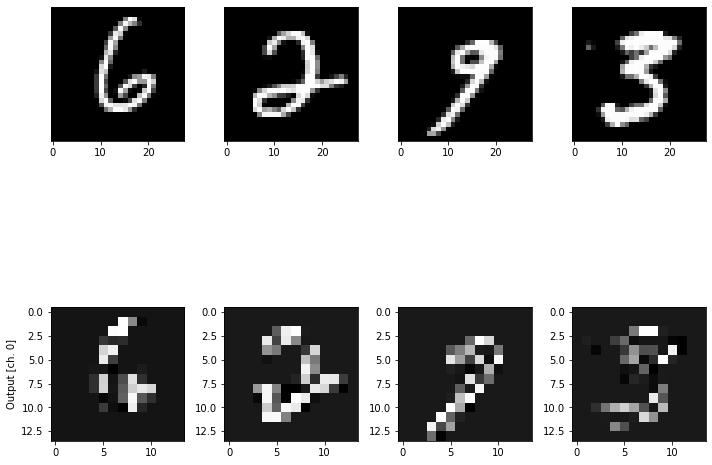

In [13]:
n_samples = 4
n_channels = 1
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    randS = random.randint(0, 50)
    axes[0, 0].set_ylabel("Input")
    if randS != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[randS, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[randS, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

In [24]:
!pip install numpy --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [16]:
!pip install nlopt


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [18]:
!pip install -U numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 33.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scipy 1.7.3 requires numpy<1.23.0,>=1.16.5, but you have numpy 1.24.2 which is incompatible.
pennylane 0.28.0 requires numpy<1.24, but you have numpy 1.24.2 which is incompatible.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.24.2 which is incompatible.


In [60]:
import pennylane as qml
from pennylane import numpy as np

import nlopt

RuntimeError: ignored

ImportError: ignored

In [58]:
import pennylane as qml
import numpy as np
#import nlopt #pip install nlopt
import random


import warnings
#warnings.filterwarnings('ignore')
!pip install pennylane-sf --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached numpy-1.23.5-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
  Using cached numpy-1.22.4-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.9 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.2
    Uninstalling numpy-1.24.2:
      Successfully uninstalled numpy-1.24.2


In [33]:
dev = qml.device("strawberryfields.fock", wires=4, cutoff_dim=4)

In [28]:
!pip install numpy --upgrade --ignore-installed

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached numpy-1.24.2-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scipy 1.7.3 requires numpy<1.23.0,>=1.16.5, but you have numpy 1.24.2 which is incompatible.
pennylane 0.28.0 requires numpy<1.24, but you have numpy 1.24.2 which is incompatible.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.24.2 which is incompatible.


In [34]:
def layer(theta, phi, wires):
    M = len(wires)
    phi_nonlinear = np.pi / 2

    qml.templates.Interferometer(
        theta, phi, np.zeros(M), wires=wires, mesh="triangular",
    )

    for i in wires:
        qml.Kerr(phi_nonlinear, wires=i)

In [35]:
@qml.qnode(dev)
def quantum_neural_net(var, x):
    wires = list(range(len(x)))

    # Encode input x into a sequence of quantum fock states
    for i in wires:
        qml.FockState(x[i], wires=i)

    # "layer" subcircuits
    for i, v in enumerate(var):
        layer(v[: len(v) // 2], v[len(v) // 2 :], wires)

    return [qml.expval(qml.NumberOperator(w)) for w in wires]

In [36]:
def square_loss(labels, predictions):
    term = 0
    for l, p in zip(labels, predictions):
        lnorm = l / np.linalg.norm(l)
        pnorm = p / np.linalg.norm(p)

        term = term + np.abs(np.dot(lnorm, pnorm.T)) ** 2

    return 1 - term / len(labels)

In [37]:
def cost(var, data_input, labels):
    predictions = np.array([quantum_neural_net(var, x) for x in data_input])
    sl = square_loss(labels, predictions)

    return sl

In [38]:
# Define the CNOT input-output states (dual-rail encoding) and initialize
# them as non-differentiable.

X = np.array([[1, 0, 1, 0],
              [1, 0, 0, 1],
              [0, 1, 1, 0],
              [0, 1, 0, 1]], requires_grad=False)

Y = np.array([[1, 0, 1, 0],
              [1, 0, 0, 1],
              [0, 1, 0, 1],
              [0, 1, 1, 0]], requires_grad=False)

In [39]:
num_layers = 2
M = len(X[0])
num_variables_per_layer = M * (M - 1)

var_init = (4 * np.random.rand(num_layers, num_variables_per_layer) - 2) * np.pi
print(var_init)

[[-0.95938209  1.8333595  -0.78430223  4.92316472  5.82655809 -1.46471707
   3.66592495  0.36310427  0.85507317  5.34820509 -5.39051987 -5.18828624]
 [-6.02911343  4.17982425  3.49542082  4.64970979  6.01449547  3.75933739
  -0.48406461  3.5252336  -4.79690504  1.75829941 -4.48175477  5.58787441]]


In [40]:
cost_grad = qml.grad(cost)

print_every = 1

# Wrap the cost so that NLopt can use it for gradient-based optimizations
evals = 0
def cost_wrapper(var, grad=[]):
    global evals
    evals += 1

    if grad.size > 0:
        # Get the gradient for `var` by first "unflattening" it
        var_grad = cost_grad(var.reshape((num_layers, num_variables_per_layer)), X, Y)
        grad[:] = var_grad.flatten()
    cost_val = cost(var.reshape((num_layers, num_variables_per_layer)), X, Y)

    if evals % print_every == 0:
        print(f"Iter: {evals:4d}    Cost: {cost_val:.4e}")

    return float(cost_val)


# Choose an algorithm
opt_algorithm = nlopt.LD_LBFGS  # Gradient-based
# opt_algorithm = nlopt.LN_BOBYQA  # Gradient-free

opt = nlopt.opt(opt_algorithm, num_layers*num_variables_per_layer)

opt.set_min_objective(cost_wrapper)

opt.set_lower_bounds(-2*np.pi * np.ones(num_layers*num_variables_per_layer))
opt.set_upper_bounds(2*np.pi * np.ones(num_layers*num_variables_per_layer))

var = opt.optimize(var_init.flatten())
var = var.reshape(var_init.shape)

NameError: ignored

In [55]:
print(f"The optimized parameters (layers, parameters):\n {var}\n")

Y_pred = np.array([quantum_neural_net(var, x) for x in X])
for i, x in enumerate(X):
    print(f"{x} --> {Y_pred[i].round(2)}, should be {Y[i]}")

NameError: ignored

In [56]:
quantum_neural_net(var_init, X[0])

tensor([0.5616478 , 0.27804632, 0.74065228, 0.41965359], requires_grad=True)

In [57]:
print(quantum_neural_net.draw())

AttributeError: ignored